# use the usual rates as proportional to IAP/Ksp ... larger distance means faster

$rate = k\left(1 - \dfrac{IAP}{Ksp}\right)$

1. start from initial conditions.
2. solve equilib problem.
3. use equilib problem to solve for rate.
4. run rate for a time step.
5. repeat from 2.


In [111]:
clear

In [112]:
function [H,OH,H2CO3,HCO3,CO3]=CspeciesopennoCa(Kw,KH,Ka1,Ka2,PCO2)

a=1; b=0; c=-Ka1*KH*PCO2-Kw; d=-Ka1*Ka2*PCO2*KH;
H=roots([a b c d]);
H=H(imag(H)==0); %sets any imaginary roots to zero
% display the positive real root
H=H(H>0);
%solve speciation
H2CO3=KH*PCO2; HCO3=(KH*PCO2*Ka1)/H; CO3=(KH*PCO2*Ka1*Ka2)/(H^2); OH=Kw/H;

end

In [113]:
function [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopennoCa(Ca,Kw,KH,Ka1,Ka2,PCO2)

a=1; b=2*Ca; c=-KH*Ka1*PCO2-Kw; d=-2*KH*Ka1*Ka2*PCO2;
H=roots([a b c d]);
H=H(imag(H)==0); %sets any imaginary roots to zero
% display the positive real root
H=H(H>0);
%solve speciation
H2CO3=KH*PCO2; HCO3=(KH*PCO2*Ka1)/H; CO3=(KH*PCO2*Ka1*Ka2)/(H^2); OH=Kw/H;

end

In [114]:
Ca(1)=1e-9; Kw=1e-14;
KH=10^-1.47;
Ka1=10^-6.3;
Ka2=10^-10.3;
PCO2=10^-6.5;
KspC=3.4e-9;
KspP=5.5e-6;
kC=1e-4;
kP=1e-3;
[H,OH,H2CO3,HCO3,CO3]=CCaspeciesopennoCa(Ca,Kw,KH,Ka1,Ka2,PCO2);
%solve for ion products
IAPP=Ca*(OH).^2;
IAPC=Ca*CO3;
%solve for the rates
rateP=kP*(1-IAPP/KspP); %mol Portlandite per second 
rateC=kC*(1-(IAPC/KspC)^1); %mol Calcite per second

In [115]:
% now do it in a loop

logtime=[0.1:0.1:3]; time=10.^logtime; time=[0 time]; % time in seconds

for i=2:length(time);
    deltat=time(i)-time(i-1);
    Ca(i)=Ca(i-1)+rateP(i-1)*deltat;
    %Ca(i)=Ca(i-1)+rateP(i-1)*deltat+rateC(i-1)*deltat;
    %CaC(i)=-rateC(i-1)*deltat;
    [H(i),OH(i),H2CO3(i),HCO3(i),CO3(i)]=CCaspeciesopennoCa(Ca(i),Kw,KH,Ka1,Ka2,PCO2);
    %solve for ion products
    IAPP(i)=Ca(i)*(OH(i)).^2;
    IAPC(i)=Ca(i)*CO3(i);
    %solve for the rates
    rateP(i)=kP*(1-IAPP(i)/KspP); %mol Portlandite per second 
    rateC(i)=kC*(1-(IAPC(i)/KspC)^1); %mol Calcite per second
end

  x=Ca(end)
  y=OH(end)

  tst=x*y.^2


x = 0.1242


y = 6.6520e-03


tst = 5.4960e-06


In [116]:
% graph
graphics_toolkit ("plotly");

subplot(221); plot(time,Ca,'ko')
subplot(222); plot(time,-log10(H),'ko')
subplot(223); plot(time,IAPP/KspP,'ko')
subplot(224); plot(time,rateP,'ko')



In [117]:
% try with od solver.  first need to define the function

function dCadt=dCa_by_dt(t,Ca)

Kw=1e-14;
KH=10^-1.47;
Ka1=10^-6.3;
Ka2=10^-10.3;
PCO2=10^-6.5;
KspC=3.4e-9;
KspP=5.5e-6;
kC=1e-4;
kP=1e-3;

[H,OH,H2CO3,HCO3,CO3]=CCaspeciesopennoCa(Ca,Kw,KH,Ka1,Ka2,PCO2);
dCadt=kP*(1-(Ca*OH^2)/KspP)+kC*(1-((Ca*CO3)/KspC));

end

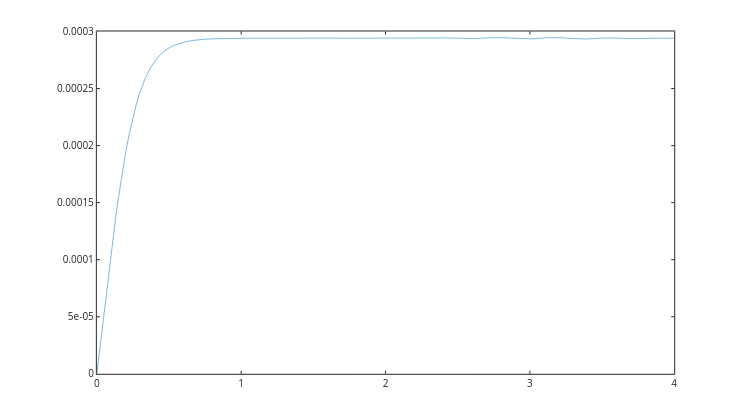

In [118]:
Ca=[1 0 1e-6]; t=0;

f=@(t,Ca) dCa_by_dt(t,Ca);
[t Catime]=ode45(f,[0 4],[0]);

plot(t,Catime)

In [119]:
% return species as function of Ca

function dC=dCa_by_dt(t,Ca)
Kw=1e-14;
KH=10^-1.47;
Ka1=10^-6.3;
Ka2=10^-10.3;
PCO2=10^-3.5;
KspC=3.4e-9;
KspP=5.5e-6;
kC=1e-5;
kP=1e-3;

[H,OH,H2CO3,HCO3,CO3]=CCaspeciesopennoCa(Ca(3),Kw,KH,Ka1,Ka2,PCO2);

dCdt=zeros(3,1);
dCdt(1)=-1*kP*(1-(Ca(3)*OH^2)/KspP);
if kC*Ca(2)*(1-((Ca(3)*CO3)/KspC))<0; dCdt(2)=-1*Ca(2)*kC*((1-((Ca(3)*CO3)/KspC))); end
dCdt(3)=kP*(1-(Ca(3)*OH^2)/KspP)+kC*Ca(2)*(1-((Ca(3)*CO3)/KspC));
dC=dCdt;
end

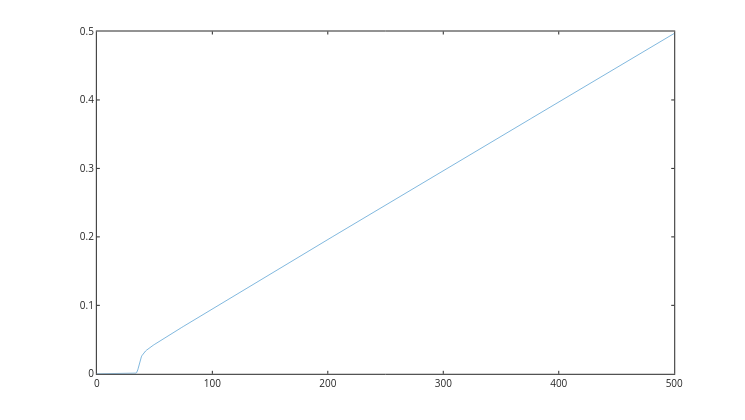

In [120]:
f=@(t,Ca) dCa_by_dt(t,Ca);

%[t, C]=ode23s(f,[0 500],[10 1e-9 1e-9]);
[t, C]=ode45(f,[0 500],[10 1e-9 1e-9]);

%C(:,1) portlandite left over
%C(:,2) CaCO3 ppte
Caplt=C(:,3); %Ca
for i=1:length(Caplt)
    [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopennoCa(Caplt(i),Kw,KH,Ka1,Ka2,PCO2);
    pH(i)=-log10(H);
end

plot(t,C(:,2))


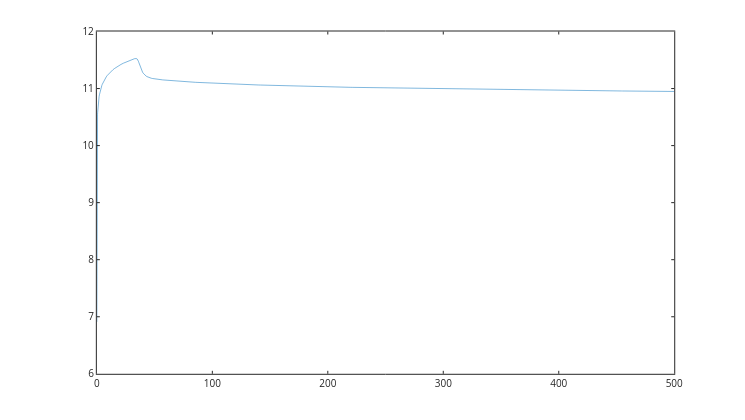

In [121]:
plot(t,pH)